# Transient Universe

Model to use:

$ f(x) = \begin{cases} b & \text{if } t < 0 \\ b + A\exp{-\alpha(t-t_0)} & \text{if } t \geq t_0 \end{cases} $

Priors:

$b \in \text{Uniform} [0,50]$\
$t_0 \in \text{Uniform} [0,100]$\
$\ln(\alpha) \text{Uniform} [-5,5]$


First, read the data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks")
from Utilities import plot_settings
import arviz as az

In [2]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Data\transient.npy")

In [3]:
time = data.T[0]
flux = data.T[1]
ferr = data.T[2]

In [4]:
import scipy

Exploring data

Text(0.5, 1.0, 'Raw data')

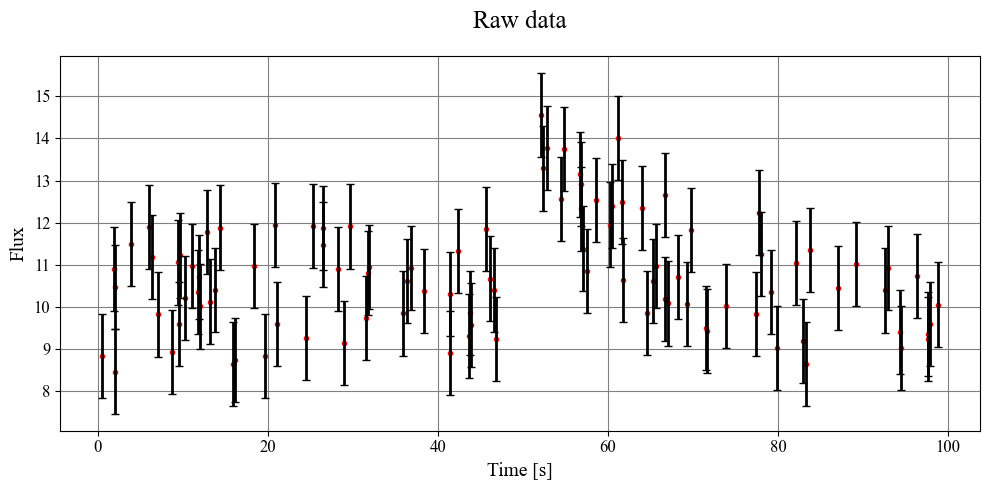

In [5]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True)
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Raw data')

Text(0.5, 1.0, 'Flux error distribution')

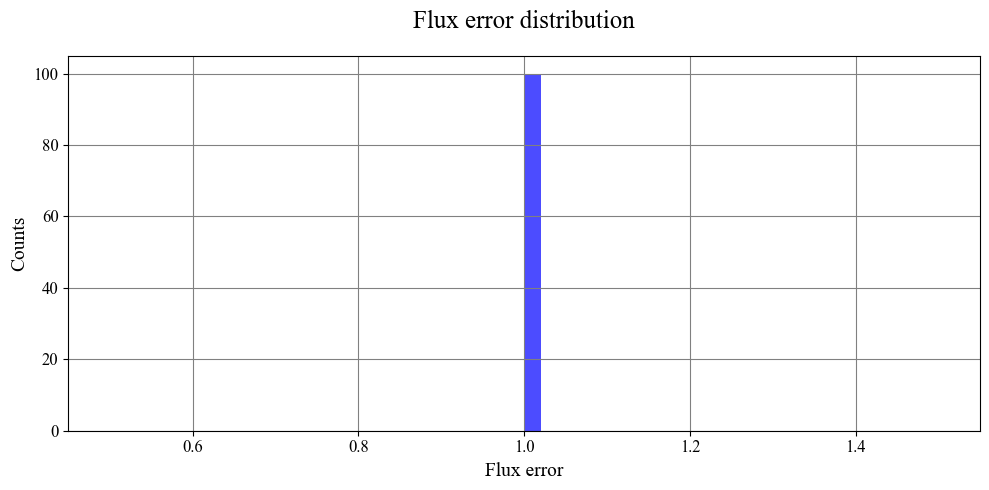

In [6]:
plt.hist(ferr, bins=50, color='blue', alpha=0.7);
plt.xlabel('Flux error')
plt.ylabel('Counts')
plt.title('Flux error distribution')

Measurement errors are homoscedastic! I can assume that the deviations between the observed values $\{y_i\}$ and the model predictions $f(\{x_i\}|\vec{\theta})$ at fixed values of $\{x_i\}$ are drawned from a Gaussian distribution with a constant scale parameter $\sigma$ .\
 This means that I can use the following likelihood:

$\mathcal{L} = \prod_{i=1}^{N} \mathcal{G}(f(x_i, \vec{\theta})|y_i, \sigma) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2}\frac{(y_i - f(x_i|\vec{\theta}))^{2}}{\sigma^{2}}}$

1. **Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{A, t_0,b,\alpha\}$.**

Define the model and initial parameters

In [7]:
def model(x):
    A, t0, alpha, b = x
    return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))

In [8]:
b_estimate = np.mean(flux[time < 40])
A_estimate = np.max(flux)-b_estimate
t0_estimate= time[np.argmax(flux)]
a = np.where(flux-b_estimate < A_estimate/np.e , time, flux)
alpha_estimate = 1/(a[a>t0_estimate][0]-t0_estimate)

In [9]:
x0 = np.array([A_estimate, t0_estimate, alpha_estimate, b_estimate])

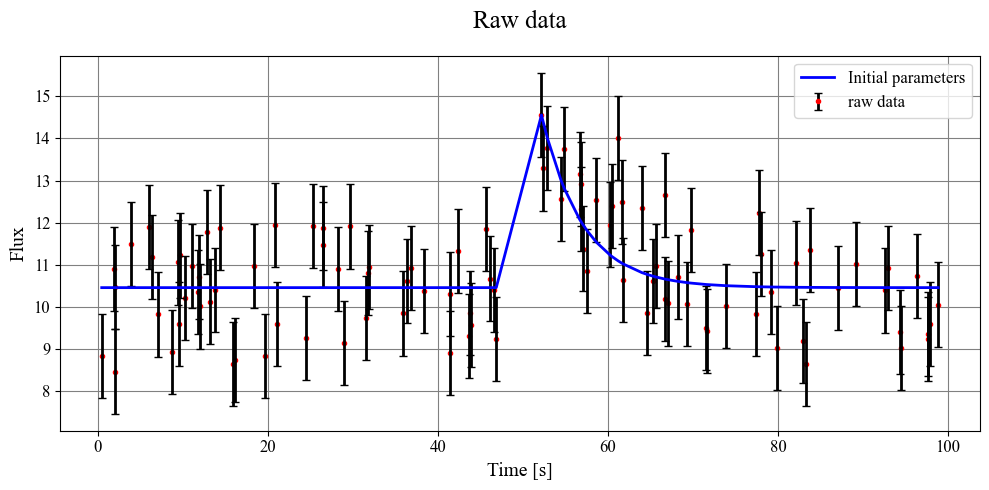

In [10]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True, label='raw data')
plt.plot(time, model(x0), lw=2, color='blue', label='Initial parameters')
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Raw data')
plt.legend()

Define loglikelihood

In [11]:
def pdf(x):
    A, t0, alpha, b = x
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    if np.any(np.isinf(np.exp(-alpha * (time - t0)))):
        return -np.inf
    output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
    return output

def prior(x):
    """
    Log prior for parameters [A, b, alpha, x0].
    Uniform priors:
    - A, b: between 0 and 50
    - alpha: between 0 and 100
    - x0: between exp(-5) and exp(5), uniform in log space
    """
    A, t0, alpha, b = x

    if not (0 <= A <= 50 and 0 <= b <= 50 and 0 <= t0 <= 100 and np.exp(-5) <= alpha <= np.exp(5)):
        return -np.inf  # outside the prior bounds

    log_prior_A     = np.log(1.0 / 50)   # uniform(0, 50)
    log_prior_b     = np.log(1.0 / 50)
    log_prior_alpha = np.log(1.0 / 100)
    log_prior_x0    = np.log(1.0 / (np.exp(5) - np.exp(-5)))

    return log_prior_A + log_prior_b + log_prior_alpha + log_prior_x0

def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, b, alpha, x0].
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * np.sum(((flux - y_model) / ferr)**2)


def posterior(x):
    """
    Log posterior function combining prior and likelihood.
    """
    
    log_prior_value = prior(x)
    if not np.isfinite(log_prior_value):
        return -np.inf

    log_like = log_likelihood(x)
    if not np.isfinite(log_like):
        return -np.inf

    return log_like + log_prior_value



In [12]:
import emcee

In [13]:
n_walkers = 10 # number of walkers I want to crawl the posterior with
n_dim = 4 # dimension of the parameter space
n_steps = int(1e5)

In [14]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, posterior, moves=emcee.moves.StretchMove(a=4.0))

In [15]:
x1 = x0 + 1e-2*np.random.randn(n_walkers,n_dim)

In [16]:
sampler.run_mcmc(initial_state=x1, nsteps=n_steps, progress=True)

100%|██████████| 100000/100000 [02:45<00:00, 604.38it/s]


State([[ 7.48533494 47.46153979  0.14174109 10.55350004]
 [ 8.17262863 47.53804252  0.14092125 10.26001879]
 [ 9.44223512 47.63023966  0.14794257 10.13630773]
 [ 4.52351965 51.62805908  0.13388138 10.35474904]
 [ 5.85974806 50.53375339  0.1453274  10.17110454]
 [ 6.91722102 47.2722801   0.10242526 10.32550436]
 [ 6.05262489 49.96447811  0.17233485 10.35225884]
 [ 6.01278889 49.67375236  0.13371088 10.23219447]
 [ 4.55946105 48.03542252  0.09062729 10.48775915]
 [ 5.99941634 50.68615629  0.19324095 10.42960292]], log_prob=[-68.77948754 -66.73876868 -68.85791883 -66.74425465 -67.96190626
 -68.41193661 -67.75416281 -66.75030016 -69.48254459 -68.96926099], blobs=None, random_state=('MT19937', array([2417067327, 2006535622,  322184491, 1028885348, 3815139122,
       2702111505,  275809435, 3959611945, 3497500420, 1193414426,
        950107338, 1609794580, 1203438377,   91270558, 1339558289,
         99021613, 2122907142, 4066773854, 1288810485, 3245277700,
        146653873, 3615459080, 369

2. **Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3)**.



In [19]:
labels = [r'$A$', r'$t_0$', r'$\alpha$', r'$b$']

In [24]:
tau = sampler.get_autocorr_time()
print(f'Autocorrelation time is {tau}')

Autocorrelation time is [85.37585675 91.78221483 68.33189428 63.27914354]


In [25]:
samples = sampler.get_chain(discard=10000, thin=int(max(np.array(tau))))
flattened = sampler.get_chain(discard=10000, thin=int(max(np.array(tau))), flat=True)

In [26]:
samples_az = np.transpose(samples, (1, 0, 2)) 

idata = az.from_dict(posterior={"theta": samples_az})

posterior = {
    "A": samples_az[:, :, 0],
    "b": samples_az[:, :, 1],
    "alpha": samples_az[:, :, 2],
    "t0": samples_az[:, :, 3],
}
idata = az.from_dict(posterior=posterior)

(-0.03, 0.03)

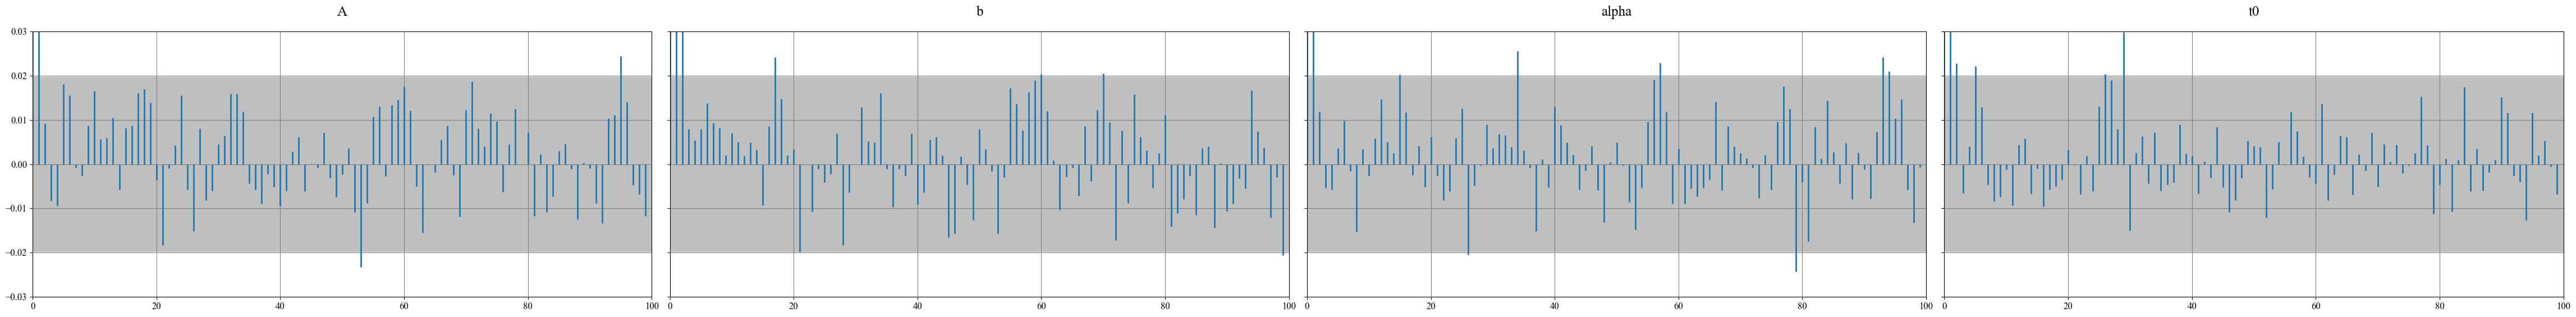

In [27]:
az.plot_autocorr(idata, var_names=["A", "b", "alpha", "t0"],
                 combined=True)

plt.ylim(-0.03,0.03)

In [28]:
acceptance_rate = sampler.acceptance_fraction
print(f'Acceptance rates are {acceptance_rate}')

Acceptance rates are [0.30177 0.2978  0.30077 0.30065 0.29925 0.30161 0.30111 0.29777 0.30171
 0.30016]


Acceptance rate is good! The sampler is exploring the posterior efficiently

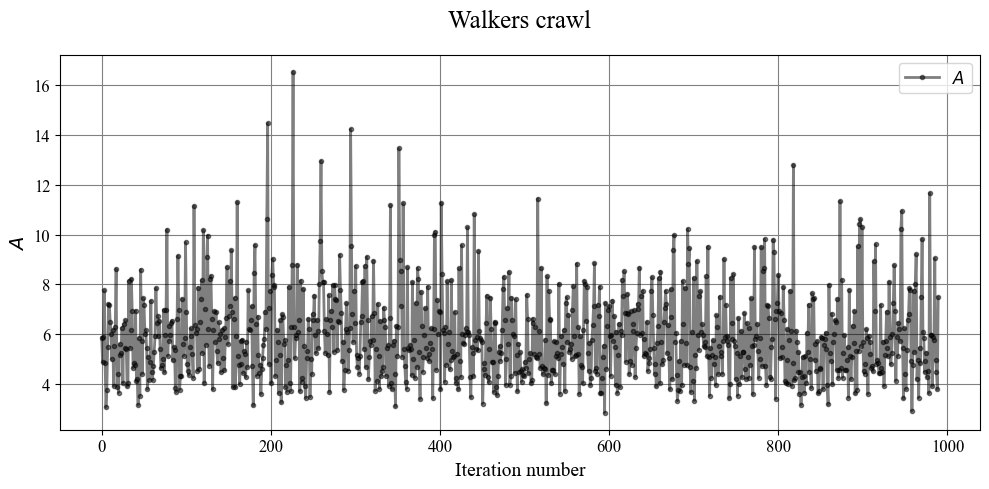

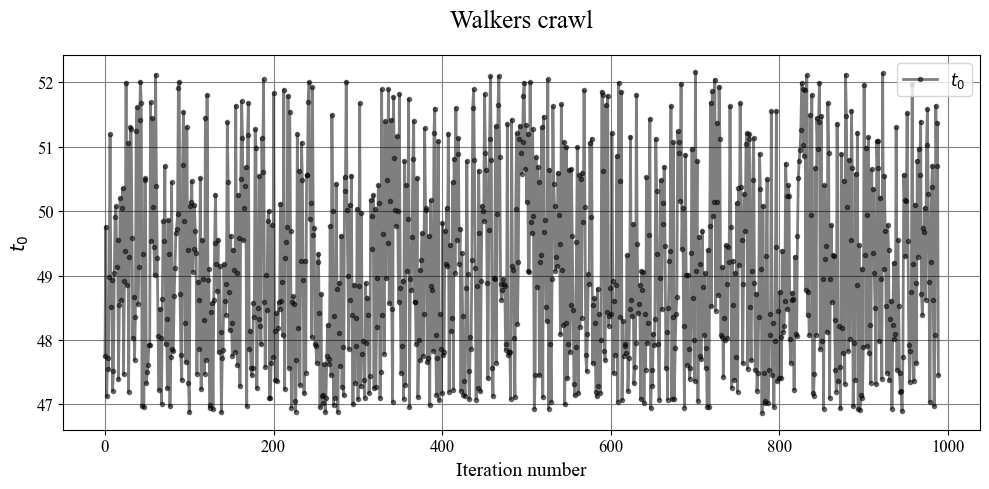

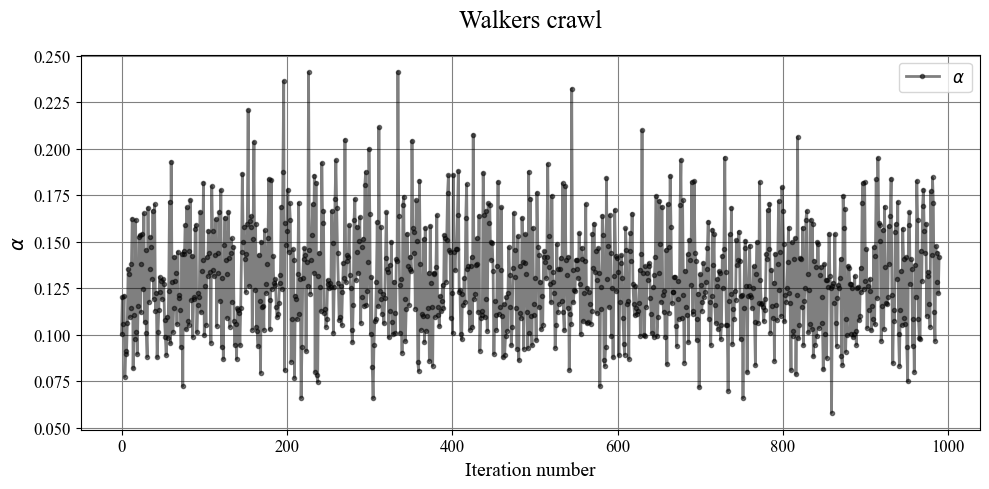

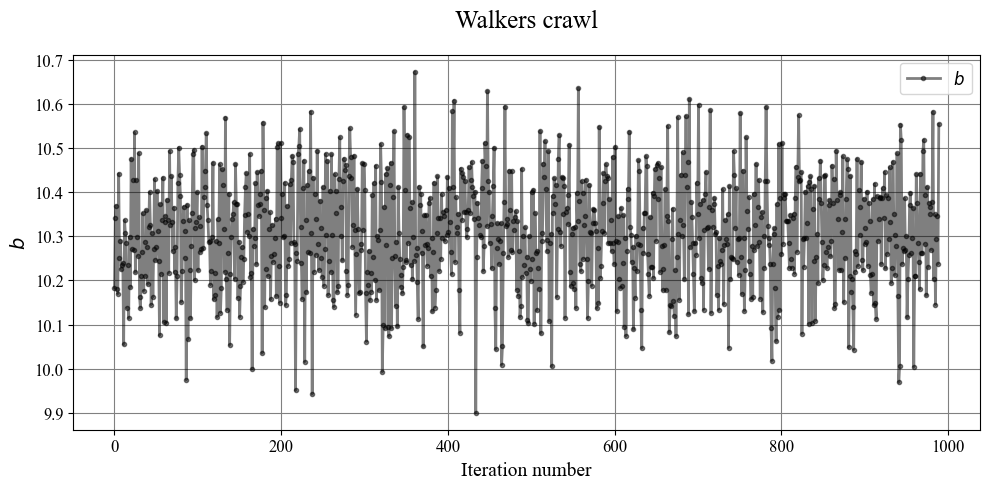

In [30]:
for i in range(n_dim):
    plt.plot(np.linspace(0,flattened[:,i][::10].size,flattened[:,i][::10].size),flattened[:,i][::10], marker='.', color='black', alpha=0.5, label=labels[i])
    plt.ylabel(labels[i])
    plt.legend()
    plt.xlabel('Iteration number')
    plt.title('Walkers crawl')
    plt.show()


3. **Make a corner plot of the $4-D$ parameter space, with labels, $[68\%,95\%]$ credible levels and quantiles, and titles**

In [31]:
import corner

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\tf-venv\lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (989) than draws (10). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


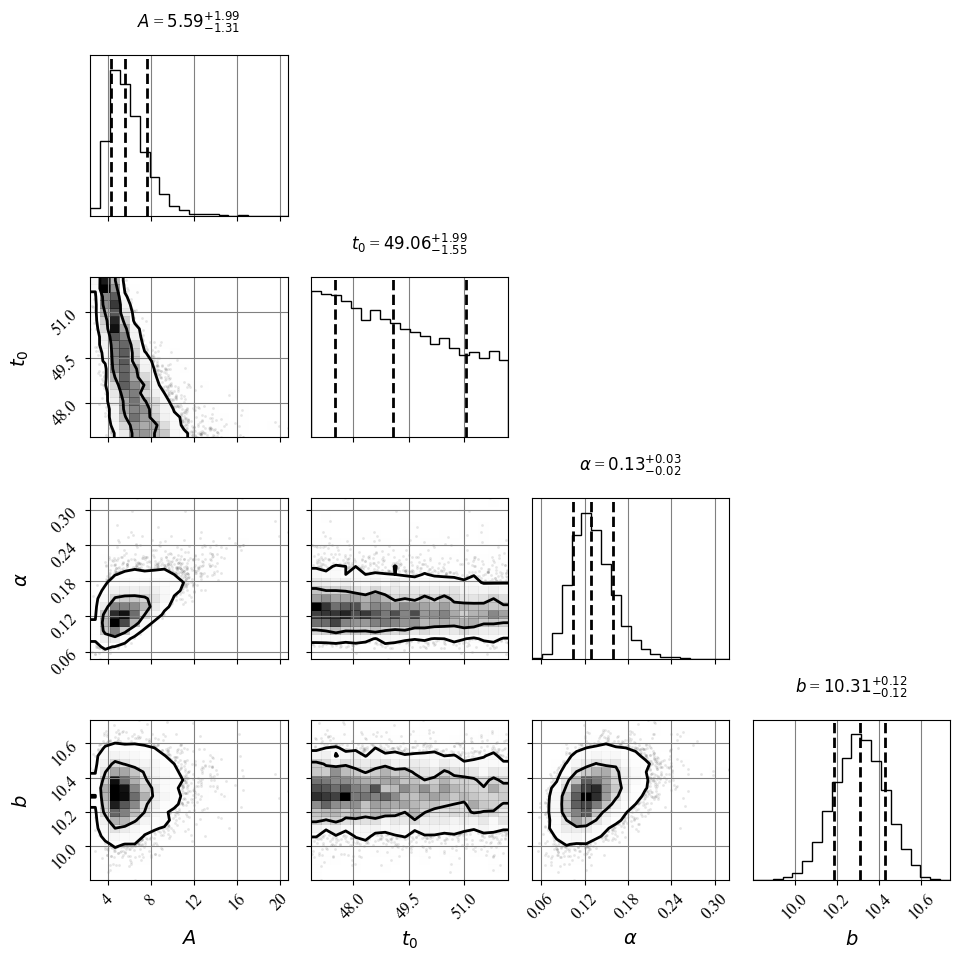

In [35]:
fig = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)

Comments on corner plot:
1. There is strong negative correlation between A and $t_0$ $\to$ if $t_0$ gets smaller then to fit the same data, $A$ has to be bigger, becouse of the decresing exponential behaviour.
2. Slight dependence of $A$ from $\alpha$: a faster decay requires a larger amplitude
3. $\alpha$ is independent from $t_0$: the time at which the signal drops is independent from the rate with which it decays, expected
3. b is largely uncorrelated with other parameters: background is not related to the other model parameters

4. **Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.**

In [39]:
flat_samples = samples.reshape(-1, samples.shape[-1])  # (n_steps * n_walkers, n_params)
randoms = np.vstack([np.random.choice(flat_samples[:,0], size=100) ,np.random.choice(flat_samples[:,1], size=100) ,np.random.choice(flat_samples[:,2], size=100), np.random.choice(flat_samples[:,3], size=100)]).T

Text(0.5, 1.0, 'Randomly chosen parameter estimates')

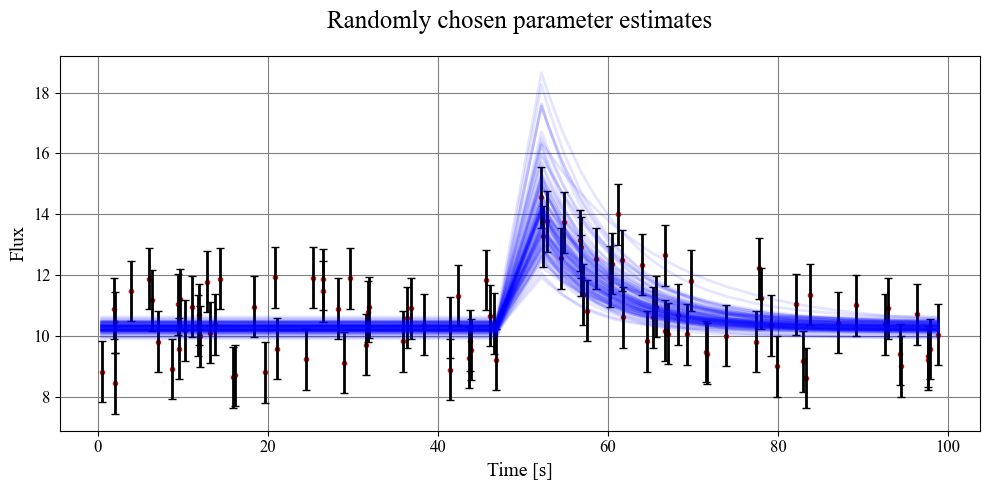

In [40]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True, label='raw data')
for ran in randoms:
    plt.plot(time, model(ran), lw=2, color='blue', alpha=0.1, label='Initial parameters')
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Randomly chosen parameter estimates')

5. **For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0 = \chi^{+Y}_{-Z}$**

In [41]:
summary = az.summary(idata, var_names=["A", "b", "alpha", "t0"], stat_focus="median", hdi_prob=0.9, kind="stats")
print(summary)

       median    mad  eti_5%  eti_95%
A       5.586  1.078   3.706    9.226
b      49.060  1.265  47.064   51.822
alpha   0.128  0.019   0.090    0.184
t0     10.309  0.085  10.106   10.508


6. **Fit the same model from before with the same priors, but this time use nested sampling.**

In [43]:
import dynesty

In [44]:
def pdf(x, model):
    A, t0, alpha, b = x
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    model: string "transient" or "gauss"\
        if "gauss" then REMEMBER that alpha parameter is the inverse of the gaussian variance!!
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    if model=="burst":
        if np.any(np.isinf(np.exp(-alpha * (time - t0)))):
            return -np.inf
        output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
        return output
    elif model=="gauss":
        if np.any(np.isinf(np.exp(-alpha * (time - t0)**2))):
            return -np.inf
        output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
        return output

t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)

def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])

   
    if model =='burst':
        x[2] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[2] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[2] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

def loglike_norm(x,model):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, t0, alpha, b].
    model: string, "burst" or "gauss"
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x,model)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * time.size * np.log(2*np.pi) - np.sum(np.log(ferr)) - 0.5 * np.sum(((flux - y_model) / ferr)**2)

In [45]:
import warnings

In [46]:
with warnings.catch_warnings():
    # Potentially dangerous, but hey I know what I'm doing. 
    # Those warnings come from regions where the likelihood is ~zero
    warnings.simplefilter("ignore", category=RuntimeWarning)
    nested_sampler_burst = dynesty.NestedSampler(loglikelihood=loglike_norm,
                                                 prior_transform=ptform, 
                                                 ndim=4, sample='rwalk', 
                                                 logl_args=["burst"], 
                                                 ptform_args=["burst"], 
                                                 nlive=500)
    nested_sampler_burst.run_nested()

7585it [13:27,  9.39it/s, +500 | bound: 79 | nc: 1 | ncall: 159002 | eff(%):  5.101 | loglstar:   -inf < -140.671 <    inf | logz: -155.072 +/-    nan | dlogz:  0.001 >  0.509]


In [57]:
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [58]:
sresults_burst = nested_sampler_burst.results

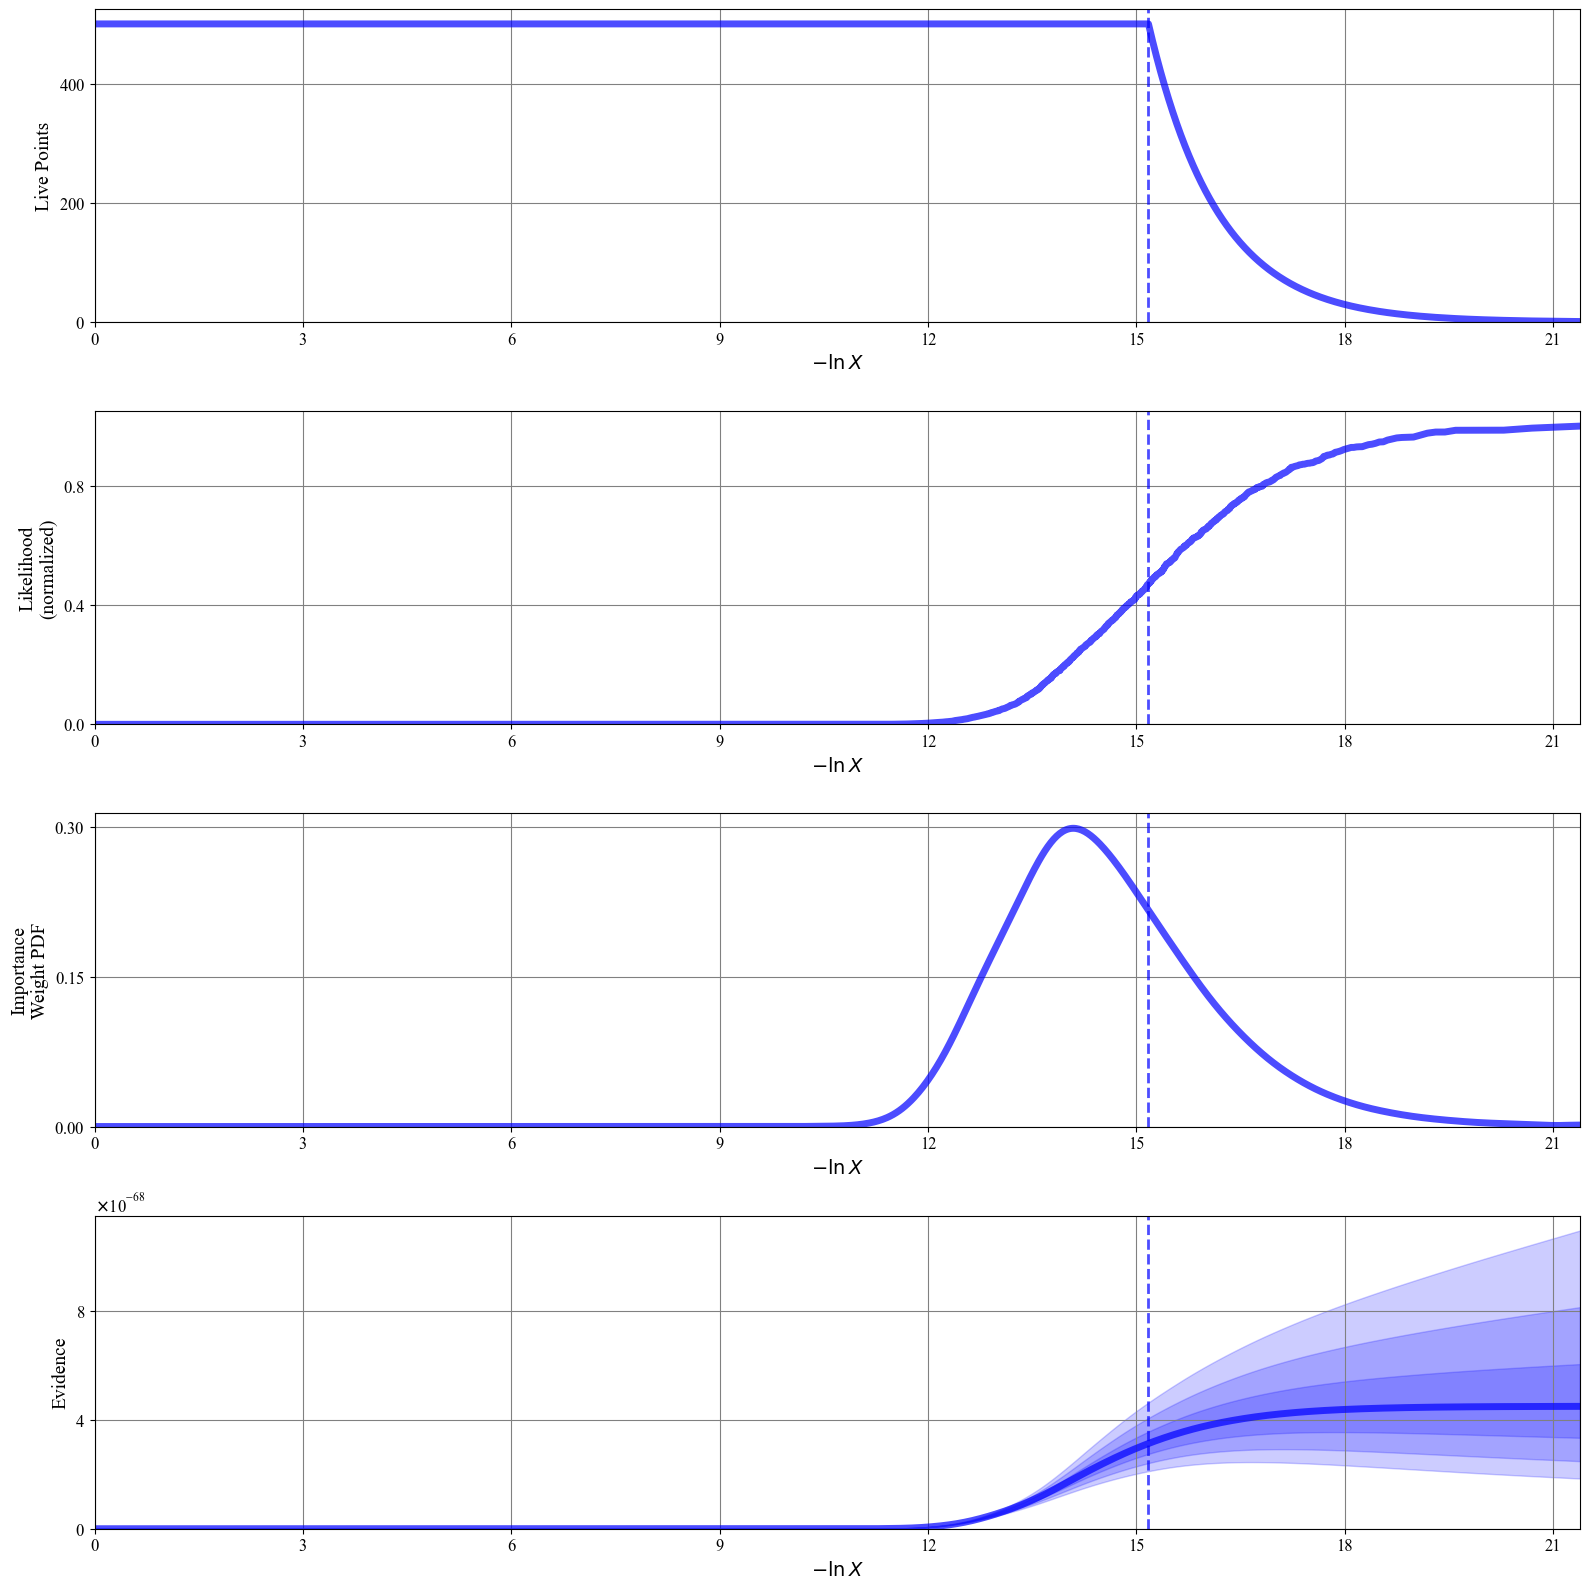

In [59]:
rfig, raxes = dyplot.runplot(sresults_burst)

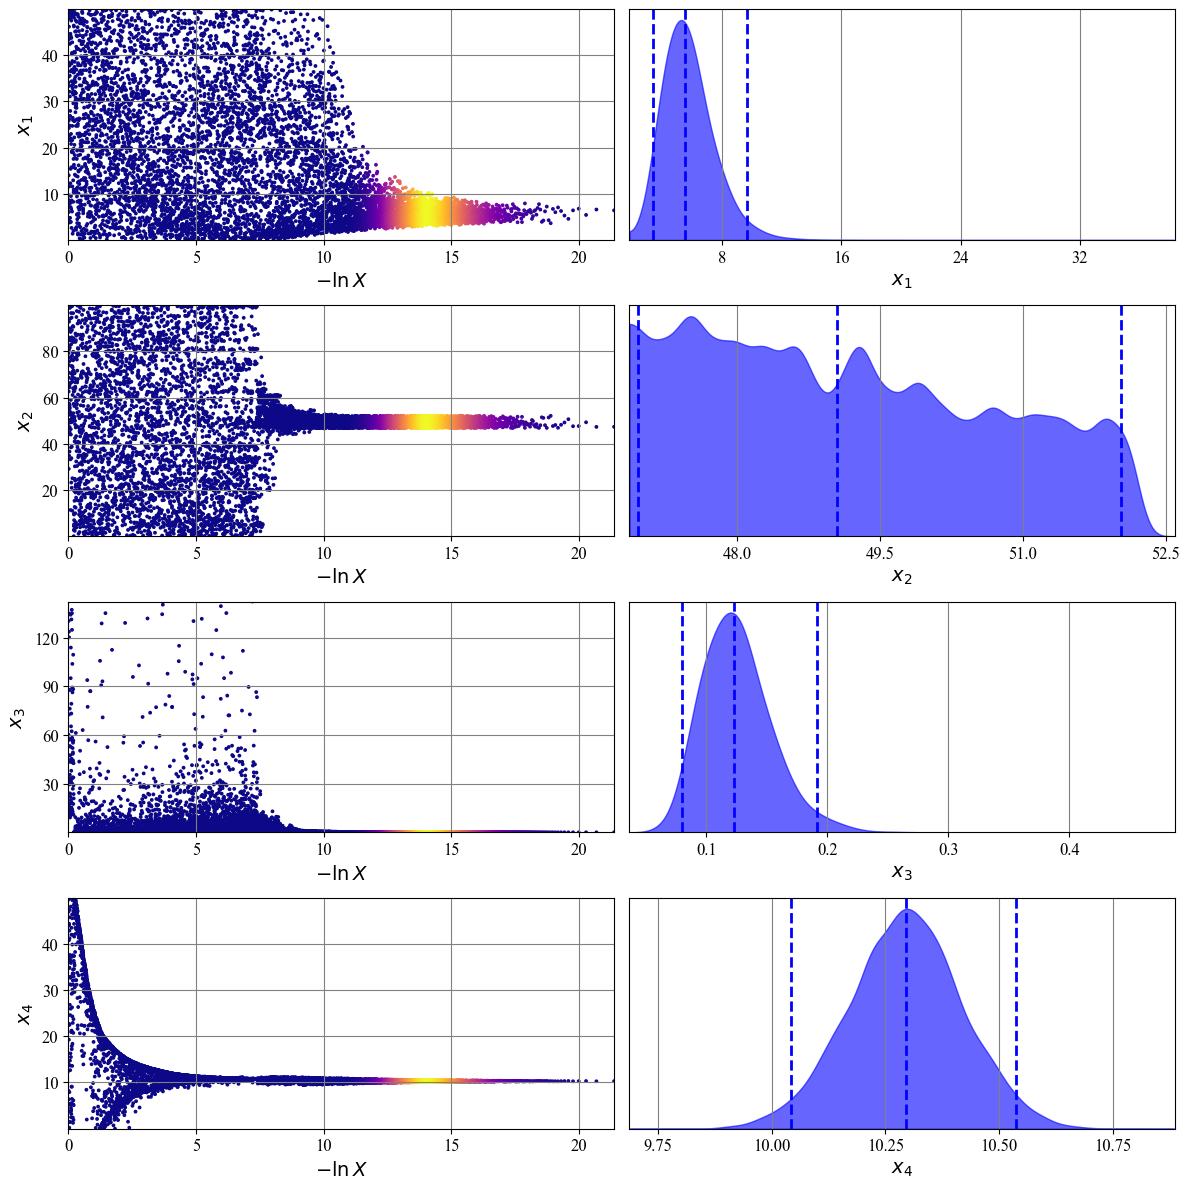

In [60]:
tfig, taxes = dyplot.traceplot(sresults_burst)

In [61]:
samples_burst = sresults_burst.samples  # samples
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])  # normalized weights

samples_equal_burst = dyfunc.resample_equal(samples_burst, weights_burst)

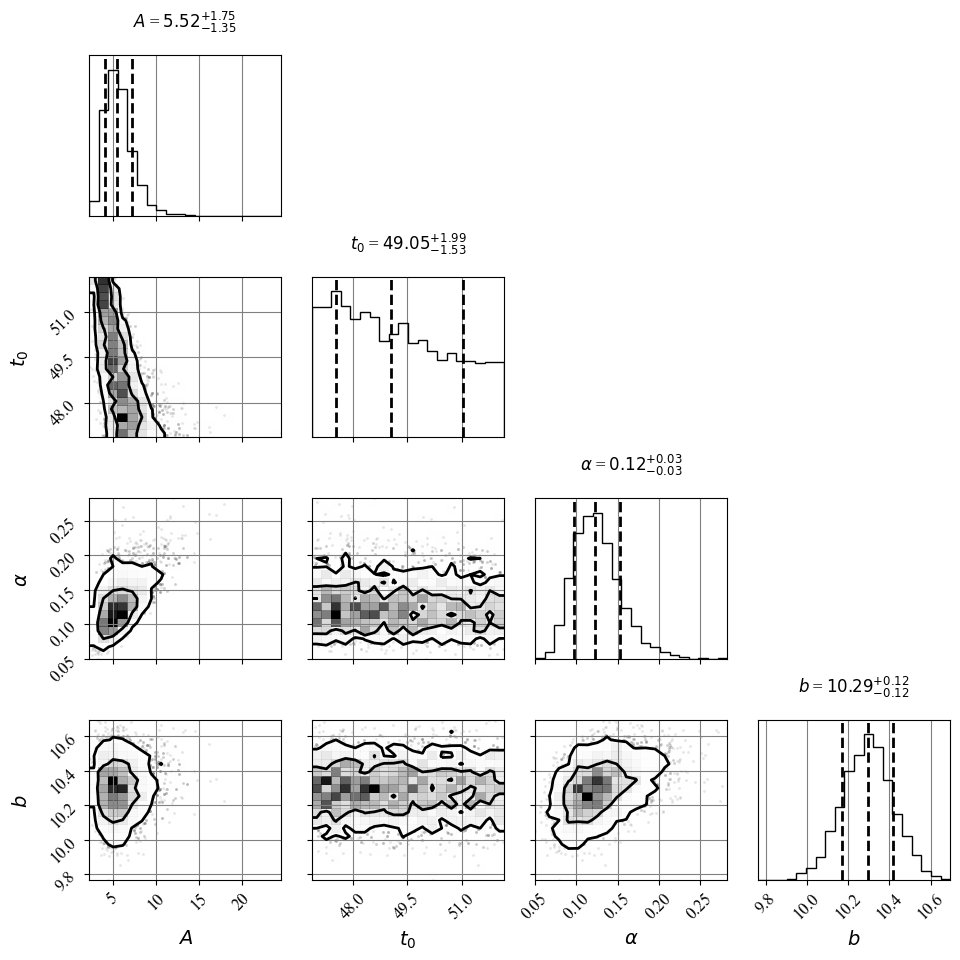

In [62]:
fig = corner.corner(
    samples_equal_burst,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     # 68% interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)

## Second Model

$y = b + \exp{\frac{-(t-t_0)^{2}}{2\sigma^{2}}}$

In [63]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    nested_sampler2 = dynesty.NestedSampler(loglikelihood=loglike_norm, prior_transform=ptform, ndim=4, sample='rwalk', logl_args=["gauss"], ptform_args=["gauss"], nlive=500)
    nested_sampler2.run_nested()

5602it [06:23, 14.62it/s, +500 | bound: 52 | nc: 1 | ncall: 110409 | eff(%):  5.552 | loglstar:   -inf < -155.361 <    inf | logz: -165.777 +/-  0.139 | dlogz:  0.001 >  0.509]


In [64]:
sresults2 = nested_sampler2.results

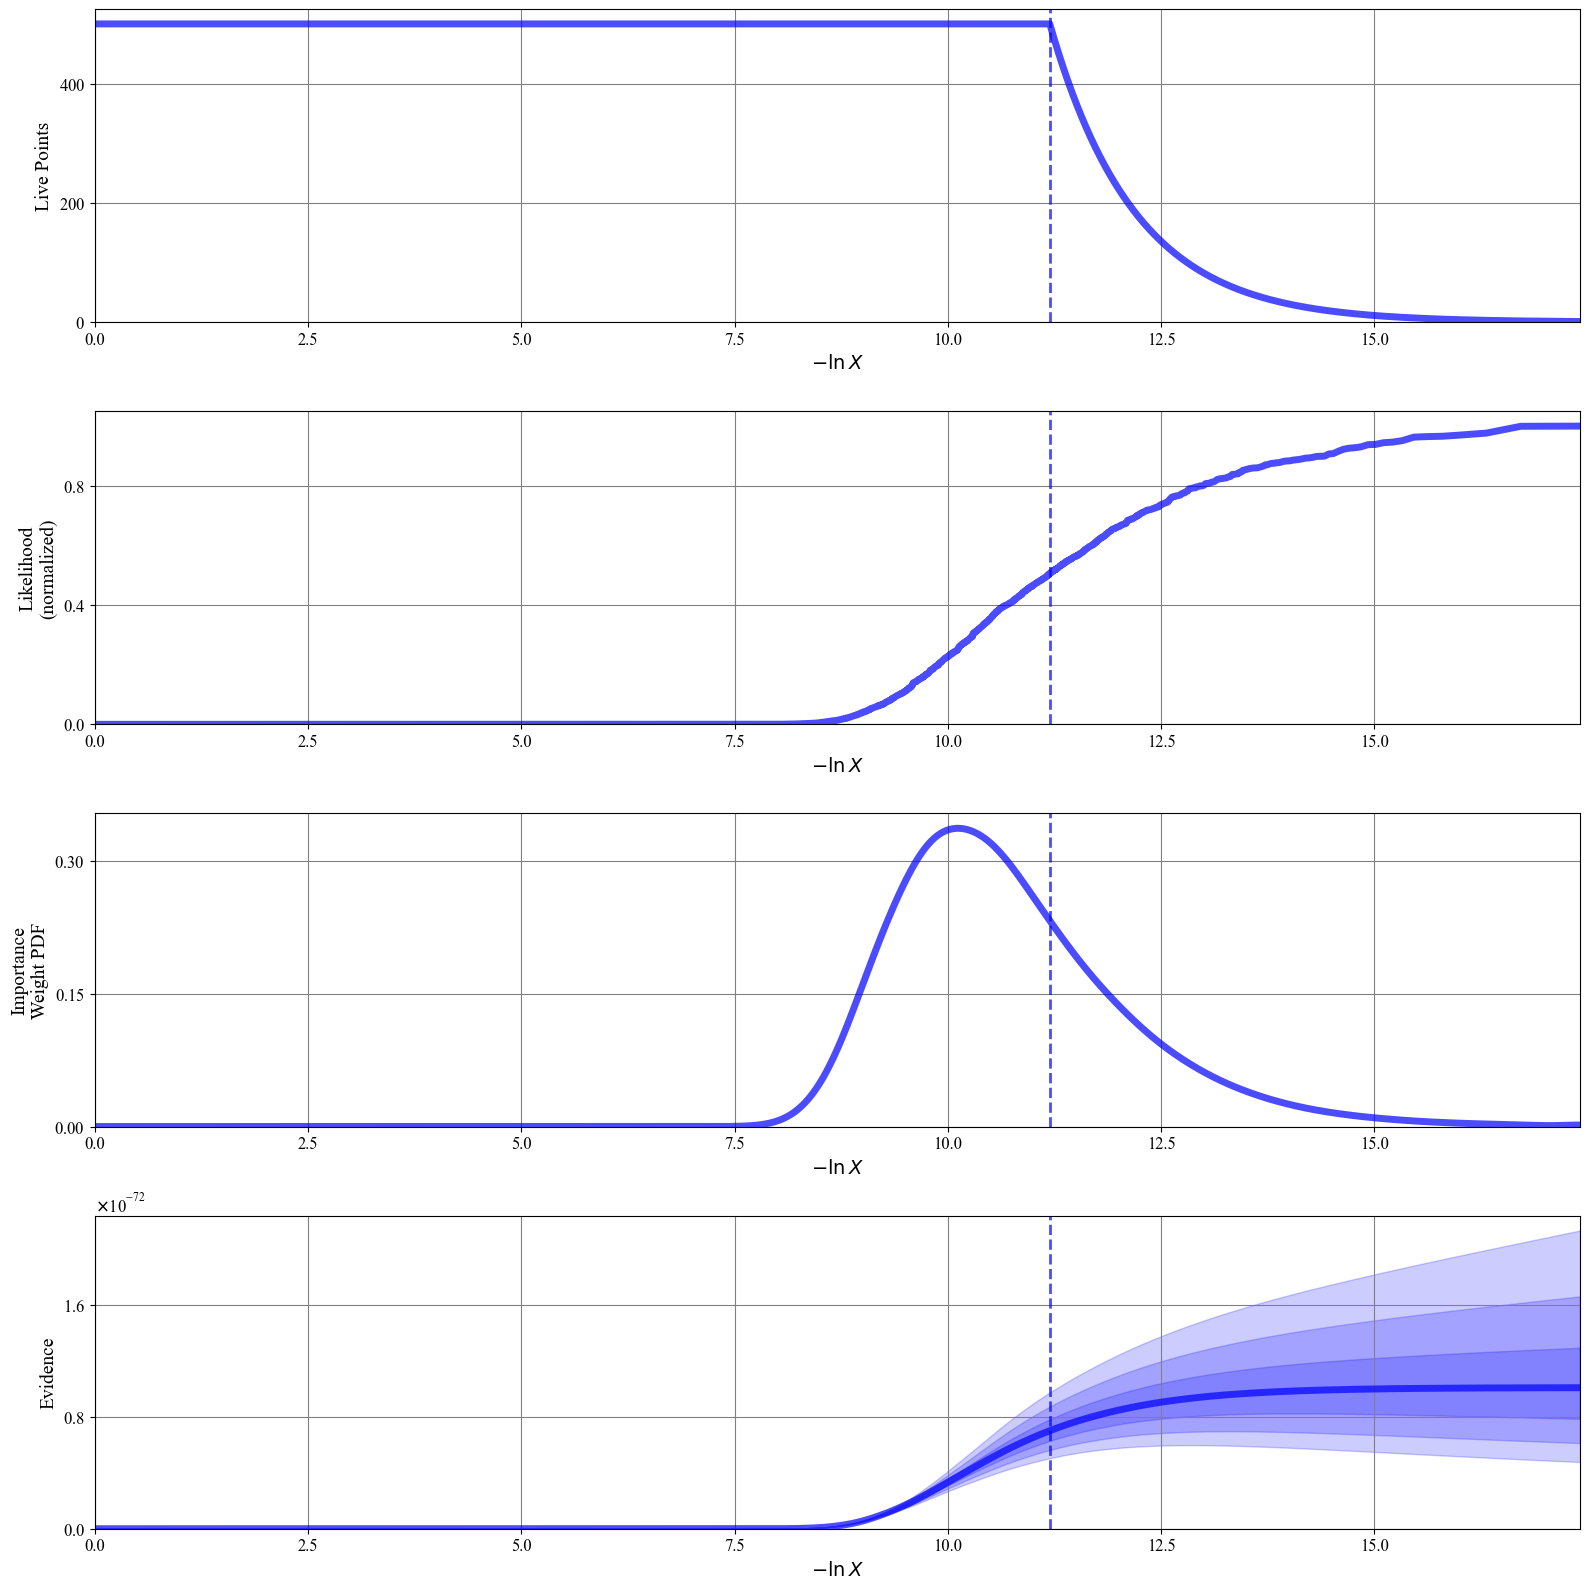

In [65]:
rfig, raxes = dyplot.runplot(sresults2)

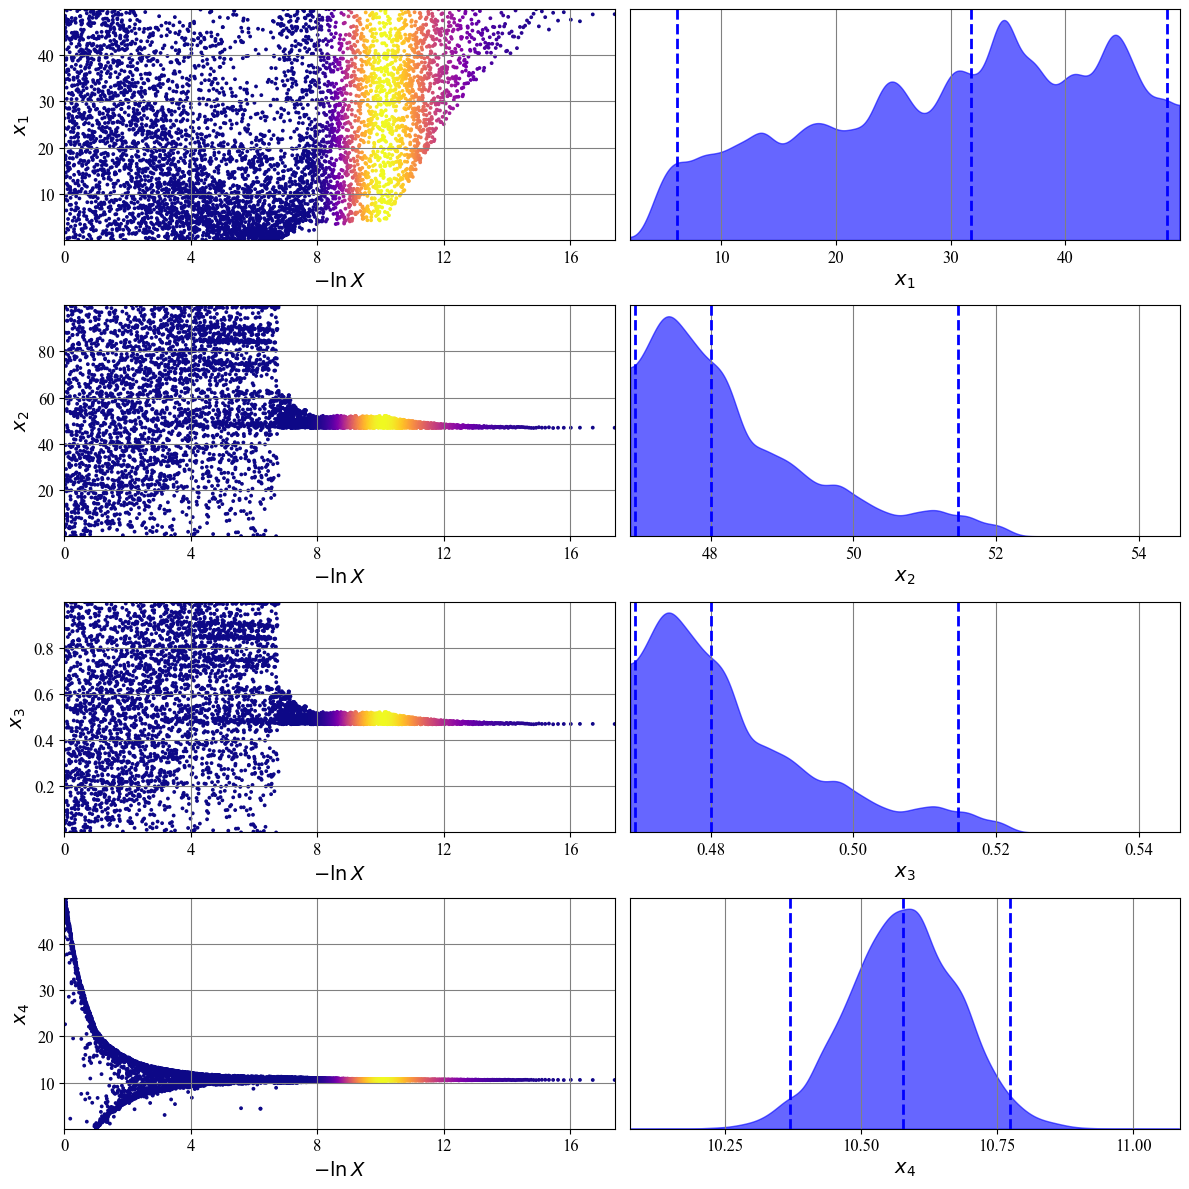

In [66]:
tfig, taxes = dyplot.traceplot(sresults2)

In [67]:
samples2 = sresults2.samples  # samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

samples_equal2 = dyfunc.resample_equal(samples2, weights2)

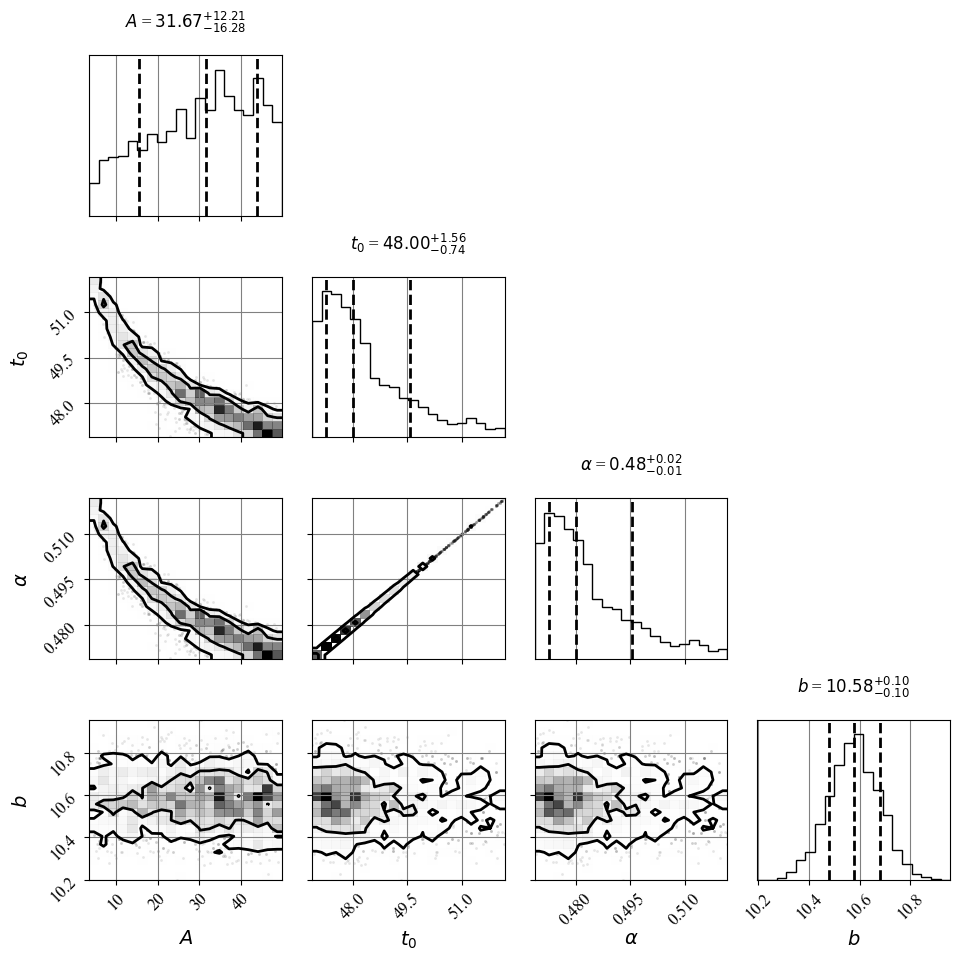

In [68]:
fig = corner.corner(
    samples_equal2,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     # 68% interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)

$A$ and $t_0$       : Positively correlated. Likely, higher amplitudes are needed to fit peaks shifted in time, compensating for changes in the central position.\
$A$ and $\alpha$    : Mild correlation. Since α controls the sharpness of the peak, fitting a sharper peak may require a different amplitude.\
$b$                 : Roughly independent of other parameters, indicating it's well separated from the peak shape in the model.



In [69]:
logZ1 = nested_sampler_burst.results.logz[-1]           # log evidence
logZ1_err = nested_sampler_burst.results.logzerr[-1]    # uncertainty

logZ2 = nested_sampler2.results.logz[-1]           # log evidence
logZ2_err = nested_sampler2.results.logzerr[-1]    # uncertainty

In [76]:
BF_12 = logZ1 - logZ2
print(f'(Log)Bayes Factor is : {BF_12:.3} +/- {np.sqrt(logZ1_err**2 + logZ2_err**2):.3}')

(Log)Bayes Factor is : 10.7 +/- 0.388


$B_{12} = 4.46 \times 10^{4} > 100 \to$ There is thus strong evidence supporting the burst model against the Gaussian bump model.